In [1]:
import os
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from IPython import display
from sam2.build_sam import build_sam2_camera_predictor

import supervision as sv
from transformers import Owlv2Processor, Owlv2ForObjectDetection
from torchvision.ops import masks_to_boxes

In [2]:
# use bfloat16 for the entire notebook
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

if torch.cuda.get_device_properties(0).major >= 8:
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

In [4]:
# Load SAM2 model
from sam2.build_sam import build_sam2_camera_predictor

sam2_checkpoint = "../checkpoints/sam2_hiera_base_plus.pt"
model_cfg = "sam2_hiera_base_plus.yaml"

predictor = build_sam2_camera_predictor(model_cfg, sam2_checkpoint)

In [5]:
# Load OWLv2 model
processor = Owlv2Processor.from_pretrained("google/owlv2-base-patch16-ensemble")
model = Owlv2ForObjectDetection.from_pretrained("google/owlv2-base-patch16-ensemble")

In [6]:
def query_detection(prompts, image, threshold=0.2):
    # Preprocess the image
    inputs = processor(text=prompts, images=image, return_tensors="pt")

    with torch.no_grad():
        outputs = model(**inputs)

    # Target image sizes (height, width) to rescale box predictions [batch_size, 2]
    target_sizes = torch.Tensor([image.shape[:2]]).repeat(len(prompts), 1)

    # Convert outputs (bounding boxes and class logits) to Pascal VOC Format (xmin, ymin, xmax, ymax)
    results = processor.post_process_object_detection(
        outputs=outputs, target_sizes=target_sizes, threshold=threshold
    )
    i = 0  # Retrieve predictions for the first image for the corresponding text queries

    detections = sv.Detections.from_transformers(results[i])

    return detections

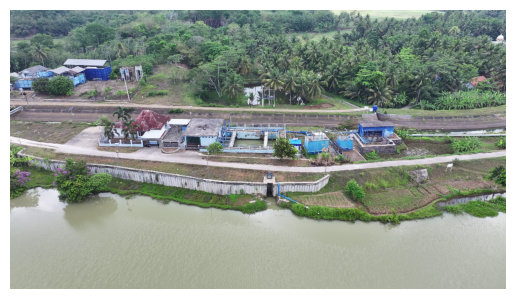

In [7]:
video_path = "./data/DJI_20241025100421_0057_D.MP4"

# Load first frame
cap = cv2.VideoCapture(video_path)
ret, frame = cap.read()

# Resize to HD resolution
frame = cv2.resize(frame, (1280, 720))

frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
cap.release()

plt.imshow(frame)
plt.axis("off")
plt.show()

In [8]:
# tracker = sv.ByteTrack(track_activation_threshold=0.10)

In [9]:
# detections = query_detection(prompts, image)
# print(detections)
# detections = tracker.update_with_detections(detections)
# print(detections)

In [10]:
from supervision.detection.overlap_filter import box_non_max_suppression

In [11]:
def calculate_iou(box1, box2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Parameters:
    - box1, box2: tuples or lists containing bounding box coordinates in the format (xmin, ymin, xmax, ymax)

    Returns:
    - iou: float, the IoU between box1 and box2
    """
    # Unpack coordinates for both boxes
    xmin1, ymin1, xmax1, ymax1 = box1
    xmin2, ymin2, xmax2, ymax2 = box2

    # Calculate the intersection coordinates
    x_inter_min = max(xmin1, xmin2)
    y_inter_min = max(ymin1, ymin2)
    x_inter_max = min(xmax1, xmax2)
    y_inter_max = min(ymax1, ymax2)

    # Calculate the area of the intersection
    inter_width = max(0, x_inter_max - x_inter_min)
    inter_height = max(0, y_inter_max - y_inter_min)
    inter_area = inter_width * inter_height

    # Calculate the area of both bounding boxes
    area_box1 = (xmax1 - xmin1) * (ymax1 - ymin1)
    area_box2 = (xmax2 - xmin2) * (ymax2 - ymin2)

    # Calculate the union area
    union_area = area_box1 + area_box2 - inter_area

    # Calculate the IoU
    iou = inter_area / union_area if union_area > 0 else 0

    return iou

In [12]:
def non_max_suppression(predictions_boxes, scores, iou_threshold=0.5):
    """
    Perform Non-Maximum Suppression (NMS) on the bounding boxes.
    Returns the indices of the boxes that should be kept.

    Parameters:
    - predictions_boxes: list of tuples or lists containing bounding box coordinates in the format (xmin, ymin, xmax, ymax)
    - scores: list of floats, the confidence scores for each bounding box
    - iou_threshold: float, the IoU threshold for NMS

    Returns:
    - indices: list of integers, the indices of the bounding boxes that should be kept
    """

    # Sort the bounding boxes by their confidence scores
    sorted_indices = np.argsort(scores)[::-1]

    # Initialize the list of indices to keep
    indices = []

    while len(sorted_indices) > 0:
        # Keep the box with the highest confidence score
        indices.append(sorted_indices[0])

        # Calculate the IoU of the first box with all other boxes
        iou = np.array([calculate_iou(predictions_boxes[sorted_indices[0]], predictions_boxes[i]) for i in sorted_indices[1:]])

        # Find the indices of boxes with IoU less than the threshold and remove them
        filtered_indices = np.where(iou <= iou_threshold)[0]
        sorted_indices = sorted_indices[filtered_indices + 1]

    return indices


In [31]:
import numpy as np
from dataclasses import dataclass, field
from typing import Optional, Dict, Union, List, Tuple

def compute_overlap_ratios(
    box_a: np.ndarray,
    box_b: np.ndarray
) -> Tuple[float, float]:
    """
    Compute the overlap ratios between two bounding boxes.

    Args:
        box_a: A NumPy array of shape `(4,)` representing the first box in `[x1, y1, x2, y2]` format.
        box_b: A NumPy array of shape `(4,)` representing the second box in `[x1, y1, x2, y2]` format.

    Returns:
        A tuple `(overlap_a, overlap_b)` where:
            - `overlap_a` is the ratio of the intersection area to the area of `box_a`.
            - `overlap_b` is the ratio of the intersection area to the area of `box_b`.
    """
    # Compute intersection coordinates
    x_left = max(box_a[0], box_b[0])
    y_top = max(box_a[1], box_b[1])
    x_right = min(box_a[2], box_b[2])
    y_bottom = min(box_a[3], box_b[3])

    # Compute intersection area
    width = max(0.0, x_right - x_left)
    height = max(0.0, y_bottom - y_top)
    inter_area = width * height

    if inter_area == 0:
        return 0.0, 0.0  # No overlap

    # Compute areas of the bounding boxes
    area_a = (box_a[2] - box_a[0]) * (box_a[3] - box_a[1])
    area_b = (box_b[2] - box_b[0]) * (box_b[3] - box_b[1])

    # Compute overlap ratios
    overlap_a = inter_area / area_a
    overlap_b = inter_area / area_b

    return overlap_a, overlap_b

def merge_boxes(boxes: np.ndarray) -> np.ndarray:
    """
    Compute the union of multiple bounding boxes.

    Args:
        boxes: A NumPy array of shape `(n, 4)` containing bounding boxes.

    Returns:
        A NumPy array of shape `(4,)` representing the merged bounding box.
    """
    x1 = np.min(boxes[:, 0])
    y1 = np.min(boxes[:, 1])
    x2 = np.max(boxes[:, 2])
    y2 = np.max(boxes[:, 3])
    return np.array([x1, y1, x2, y2])

def merge_overlapping_detections(
    detections: sv.Detections,
    threshold: float
) -> sv.Detections:
    """
    Merge detections that significantly overlap with each other based on
    a specified overlap threshold. When merging detections with different
    class IDs, the class ID of the detection with the larger area is assigned.

    Args:
        detections: A `Detections` object containing bounding boxes and associated data.
        threshold: The overlap percentage threshold (between 0 and 1).

    Returns:
        A new `Detections` object with overlapping detections merged.
    """
    if not 0 <= threshold <= 1:
        raise ValueError("Threshold must be between 0 and 1.")

    boxes = detections.xyxy  # (n, 4) array
    n = boxes.shape[0]
    class_ids = detections.class_id if detections.class_id is not None else np.zeros(n, dtype=int)

    # Compute areas of all bounding boxes
    areas = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])

    # Initialize an adjacency list for grouping
    groups = []
    # Initialize a list to keep track of which detections have been assigned to a group
    assigned = [False] * n

    # Build the graph of overlapping boxes
    overlap_graph = [[] for _ in range(n)]
    for i in range(n):
        for j in range(i + 1, n):
            overlap_i, overlap_j = compute_overlap_ratios(boxes[i], boxes[j])
            if overlap_i >= threshold or overlap_j >= threshold:
                # Add edges in both directions
                overlap_graph[i].append(j)
                overlap_graph[j].append(i)

    # Perform DFS to find connected components (groups)
    def dfs(node, group):
        assigned[node] = True
        group.append(node)
        for neighbor in overlap_graph[node]:
            if not assigned[neighbor]:
                dfs(neighbor, group)

    # Find all groups
    for i in range(n):
        if not assigned[i]:
            group = []
            dfs(i, group)
            groups.append(group)

    # Now merge the detections in each group
    new_boxes = []
    new_confidences = []
    new_class_ids = []
    new_masks = []
    new_tracker_ids = []
    new_data = {key: [] for key in detections.data} if detections.data else {}

    for group in groups:
        group_boxes = boxes[group]
        group_areas = areas[group]
        group_class_ids = class_ids[group]

        # Merge the bounding boxes
        merged_box = merge_boxes(group_boxes)
        new_boxes.append(merged_box)

        # Handle confidence scores (e.g., take the maximum confidence)
        if detections.confidence is not None:
            group_confidences = detections.confidence[group]
            merged_confidence = np.max(group_confidences)
            new_confidences.append(merged_confidence)

        # Assign class ID of the detection with the largest area
        largest_area_index = group[np.argmax(group_areas)]
        merged_class_id = class_ids[largest_area_index]
        new_class_ids.append(merged_class_id)

        # Handle masks (assuming binary masks, combine using logical OR)
        if detections.mask is not None:
            group_masks = detections.mask[group]
            merged_mask = np.any(group_masks, axis=0)
            new_masks.append(merged_mask)

        # Handle tracker IDs (you may choose to keep one of them or assign a new ID)
        if detections.tracker_id is not None:
            group_tracker_ids = detections.tracker_id[group]
            merged_tracker_id = group_tracker_ids[np.argmax(group_areas)]  # Corresponds to largest area
            new_tracker_ids.append(merged_tracker_id)

        # Handle additional data
        if detections.data:
            for key, values in detections.data.items():
                group_values = values[group]
                # You can decide how to merge the data; here we take the value from the detection with the largest area
                merged_value = group_values[np.argmax(group_areas)]
                new_data[key].append(merged_value)

    # Convert lists to numpy arrays
    new_boxes = np.array(new_boxes)
    new_confidences = np.array(new_confidences) if new_confidences else None
    new_class_ids = np.array(new_class_ids) if new_class_ids else None
    new_masks = np.array(new_masks) if new_masks else None
    new_tracker_ids = np.array(new_tracker_ids) if new_tracker_ids else None
    new_data = {key: np.array(values) for key, values in new_data.items()} if new_data else {}

    # Create the new Detections object
    merged_detections = sv.Detections(
        xyxy=new_boxes,
        mask=new_masks,
        confidence=new_confidences,
        class_id=new_class_ids,
        tracker_id=new_tracker_ids,
        data=new_data
    )

    return merged_detections


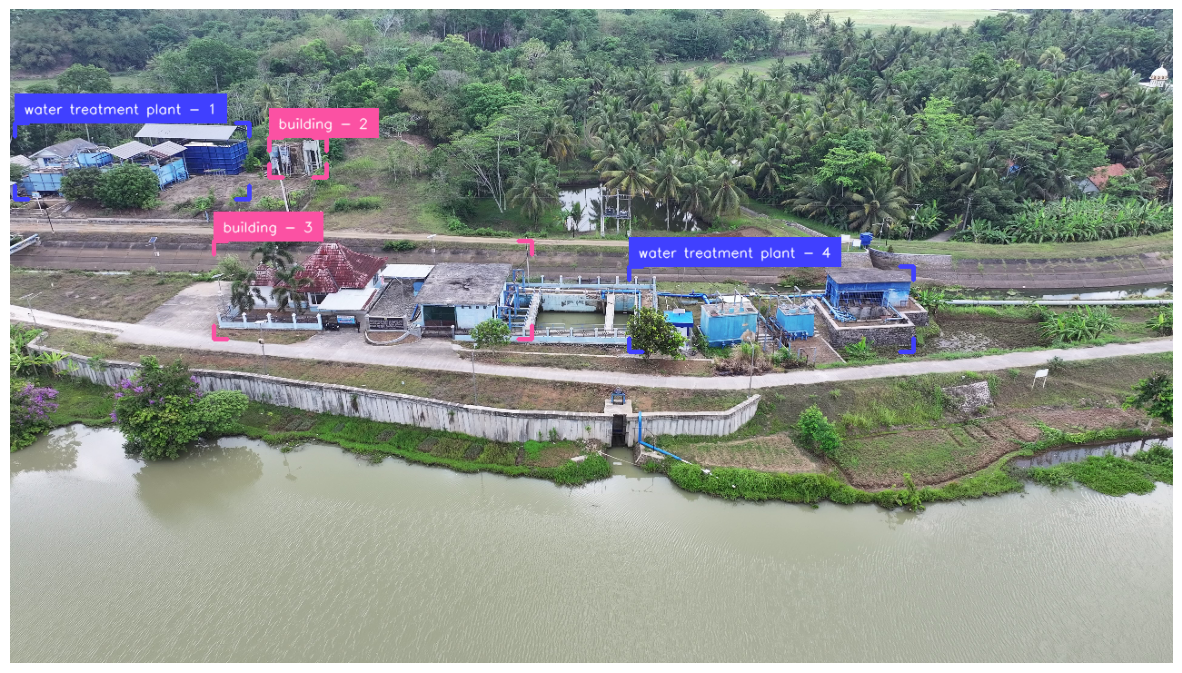

In [32]:
# Predict the bounding boxes using OWL-V2
labels = ["building", "water treatment plant"]
prompts = [labels]

detections = query_detection(prompts, frame, threshold=0.2)
detections = merge_overlapping_detections(detections, threshold=0.25)
# detections = merge_overlapping_detections(detections, threshold=0.25)
# keep_idx = non_max_suppression(detections.xyxy, detections.confidence, iou_threshold=0.25)
# largest_conf_floodgate = detections.confidence[detections.class_id == 2].argmax()

# detections = detections[keep_idx]


# detections = tracker.update_with_detections(detections)
detections.tracker_id = np.arange(len(detections)) + 1

corner_annotator = sv.BoxCornerAnnotator()
label_annotator = sv.LabelAnnotator()
annotated_frame = corner_annotator.annotate(
    scene=frame.copy(),
    detections=detections
)

annotated_frame = label_annotator.annotate(
    scene=annotated_frame,
    detections=detections,
    labels=[f"{labels[idx]} - {tracker_id}" for idx, tracker_id in zip(detections.class_id, detections.tracker_id)]
    # labels=[f"{labels[idx]}" for idx in ÷detections.class_id]
    
)
fig = plt.figure(figsize=(15, 10))
plt.imshow(annotated_frame)
plt.axis("off")
plt.show()

In [34]:
def detection_from_segmentation(detections, out_obj_ids, out_mask_logits):
    tracker_id_to_obj_id = {detections.tracker_id[i]: i for i in range(len(detections))}

    # Update the mask for each detection
    out_masks = out_mask_logits[:, 0, ...].cpu().numpy() > 0.0
    total_area = np.sum(out_masks, axis=(1, 2))

    # Filter out masks with area less than 50
    out_masks = out_masks[total_area > 50]

    detections.mask = np.zeros(
        (len(detections), out_masks.shape[1], out_masks.shape[2]), dtype=bool
    )

    segmentation_bbox = masks_to_boxes(torch.tensor(out_masks).float()).numpy()

    valid_detections = []

    for obj_id, object_mask in zip(out_obj_ids, out_masks):
        if obj_id not in tracker_id_to_obj_id:
            continue
        detection_idx = tracker_id_to_obj_id[obj_id]
        valid_detections.append(detection_idx)

        # Update detection with the mask
        detections.mask[detection_idx] = object_mask

        # Update detection with the segmentation bbox
        detections.xyxy[detection_idx] = segmentation_bbox[detection_idx]

    return detections[valid_detections]

In [35]:
corner_annotator = sv.BoxCornerAnnotator(color_lookup=sv.ColorLookup.TRACK)
label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.TRACK)
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.TRACK)

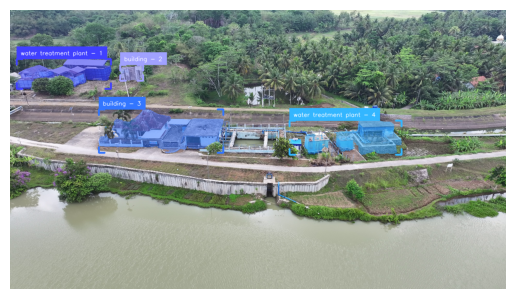

In [36]:
# Add first frame to sam2 predictor
predictor.load_first_frame(frame)
ann_frame_idx = 0

for ann_obj_id in range(len(detections)):
    box = detections.xyxy[ann_obj_id]
    bbox = np.array([box[:2], box[2:]])
    _, out_obj_ids, out_mask_logits = predictor.add_new_prompt(
        frame_idx=ann_frame_idx, obj_id=detections.tracker_id[ann_obj_id], bbox=bbox
    )

detections = detection_from_segmentation(detections, out_obj_ids, out_mask_logits)

annotated_frame = corner_annotator.annotate(scene=frame.copy(), detections=detections)

annotated_frame = label_annotator.annotate(
    scene=annotated_frame,
    detections=detections,
    labels=[
        f"{labels[idx]} - {tracker_id}"
        for idx, tracker_id in zip(detections.class_id, detections.tracker_id)
    ],
)

annotated_frame = mask_annotator.annotate(
    scene=annotated_frame,
    detections=detections
)

plt.imshow(annotated_frame)
plt.axis("off")
plt.show()

In [37]:
output_dir = "./new/"
os.makedirs(output_dir, exist_ok=True)

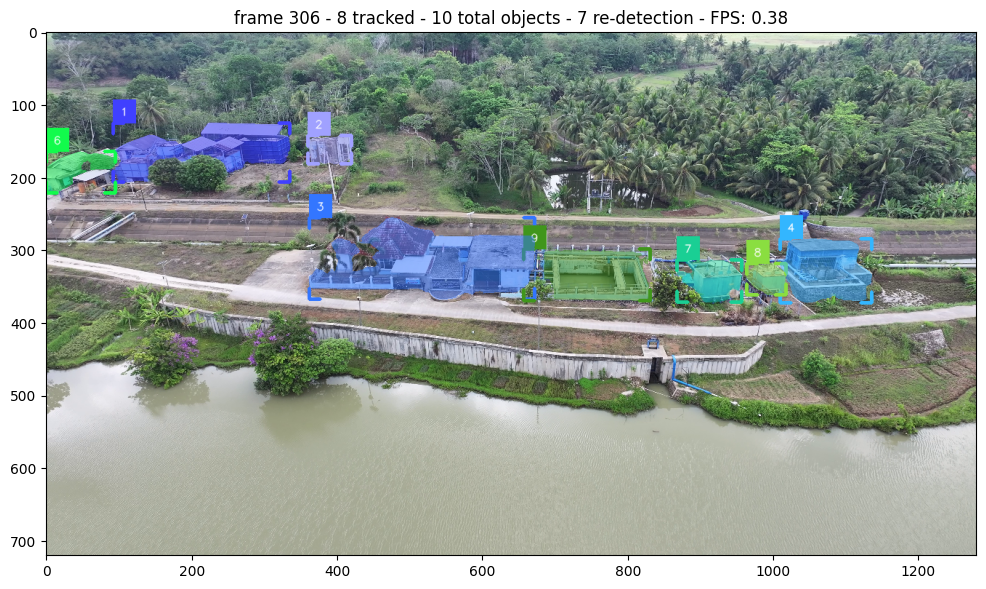

OutOfMemoryError: CUDA out of memory. Tried to allocate 3.50 GiB. GPU 0 has a total capacity of 14.75 GiB of which 3.42 GiB is free. Process 426793 has 11.33 GiB memory in use. Of the allocated memory 10.51 GiB is allocated by PyTorch, and 714.21 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [38]:
import time

# Predict the bounding boxes using OWL-V2
labels = ["building", "water treatment plant"]
prompts = [labels]

redetect_interval = 100
max_id = 0

# tracker = sv.ByteTrack(track_activation_threshold=0.05)
total_new_detected = 0

# Calculate FPS
start_time = time.time()

try:
    cap = cv2.VideoCapture(video_path)
    frame_idx = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        frame = cv2.resize(frame, (1280, 720))
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        width, height = frame.shape[:2][::-1]

        if frame_idx == 0:
            predictor.reset_state()
            predictor.load_first_frame(frame)

            detections = query_detection(prompts, frame)
            detections = merge_overlapping_detections(detections, threshold=0.25)
            # keep_idx = non_max_suppression(
            #     detections.xyxy, detections.confidence, iou_threshold=0.25
            # )
            # detections = detections[keep_idx]
            total_new_detected = len(detections)
            detections.tracker_id = np.arange(0, len(detections)) + max_id + 1

            for ann_obj_id in range(len(detections)):
                box = detections.xyxy[ann_obj_id]
                obj_id = detections.tracker_id[ann_obj_id]
                bbox = np.array([box[:2], box[2:]])
                _, out_obj_ids, out_mask_logits = predictor.add_new_prompt(
                    frame_idx=0, obj_id=obj_id, bbox=bbox
                )

            detections = detection_from_segmentation(
                detections, out_obj_ids, out_mask_logits
            )
            max_id = max(max_id, detections.tracker_id.max())

        elif frame_idx != 0 and frame_idx % redetect_interval == 0:
            new_detections = query_detection(prompts, frame)
            new_detections = merge_overlapping_detections(new_detections, threshold=0.25)
            # keep_idx = non_max_suppression(
            #     detections.xyxy, detections.confidence, iou_threshold=0.25
            # )
            # detections = detections[keep_idx]

            total_new_detected = len(new_detections)
            valid_new_detection_idx = []

            # Add new detections if they do not overlap with existing detections
            for new_det_idx in range(len(new_detections)):
                new_det = new_detections.xyxy[new_det_idx]

                # Check if the new detection overlaps with any existing detection
                for det in detections.xyxy:
                    new_det_overlap, det_overlap = compute_overlap_ratios(new_det, det)
                    if new_det_overlap > 0.25 or det_overlap > 0.25:
                        break
                else:
                    valid_new_detection_idx.append(new_det_idx)
                    

                # ious = [calculate_iou(new_det, det) for det in detections.xyxy]
                # if all(iou < 0.25 for iou in ious):
                #     valid_new_detection_idx.append(new_det_idx)

            new_detections = new_detections[valid_new_detection_idx]
            new_detections.mask = np.zeros(
                (len(new_detections), frame.shape[0], frame.shape[1]), dtype=bool
            )

            if len(new_detections) > 0:
                new_detections.tracker_id = np.arange(0, len(new_detections)) + max_id + 1

                detections = sv.Detections.merge([detections, new_detections])

                predictor.reset_state()
                predictor.load_first_frame(frame)

                for ann_obj_id in range(len(detections)):
                    box = detections.xyxy[ann_obj_id]
                    obj_id = detections.tracker_id[ann_obj_id]
                    bbox = np.array([box[:2], box[2:]])
                    _, out_obj_ids, out_mask_logits = predictor.add_new_prompt(
                        frame_idx=0, obj_id=obj_id, bbox=bbox
                    )

                detections = detection_from_segmentation(
                    detections, out_obj_ids, out_mask_logits
                )

                max_id = max(max_id, detections.tracker_id.max())

        else:
            out_obj_ids, out_mask_logits = predictor.track(frame)
            detections = detection_from_segmentation(
                detections, out_obj_ids, out_mask_logits
            )

        annotated_frame = corner_annotator.annotate(
            scene=frame.copy(), detections=detections
        )

        annotated_frame = label_annotator.annotate(
            scene=annotated_frame,
            detections=detections,
            labels=[
                f"{tracker_id}"
                for idx, tracker_id in zip(detections.class_id, detections.tracker_id)
            ],
        )

        annotated_frame = mask_annotator.annotate(
            scene=annotated_frame, detections=detections
        )

        current_time = time.time()
        fps = (frame_idx + 1) / (current_time - start_time)

        display.clear_output(wait=True)
        plt.figure(figsize=(12, 8))
        plt.title(
            f"frame {frame_idx} - {len(detections)} tracked - {max_id + 1} total objects - {total_new_detected} re-detection - FPS: {fps:.2f}"
        )
        plt.imshow(annotated_frame)
        plt.show()

        # Save the annotated frame
        output_path = os.path.join(output_dir, f"frame_{str(frame_idx).zfill(5)}.png")
        cv2.imwrite(output_path, cv2.cvtColor(annotated_frame, cv2.COLOR_RGB2BGR))

        frame_idx += 1

finally:
    cap.release()

In [ ]:
from tqdm import tqdm

In [ ]:
# Save the annotated video with opencv
output_video_path = os.path.join(output_dir, "annotated_video_2.mp4")
frame_paths = sorted([os.path.join(output_dir, image_name) for image_name in os.listdir(output_dir)])

frame = cv2.imread(frame_paths[0])
height, width, _ = frame.shape

fourcc = cv2.VideoWriter_fourcc(*"mp4v")
video_writer = cv2.VideoWriter(output_video_path, fourcc, 30, (width, height))

for frame_path in tqdm(frame_paths):
    frame = cv2.imread(frame_path)
    video_writer.write(frame)

video_writer.release()

  9%|▉         | 74/810 [00:01<00:11, 61.82it/s]

100%|██████████| 810/810 [00:12<00:00, 62.45it/s]


In [ ]:
from torchvision.ops import masks_to_boxes

masks_to_boxes(out_mask_logits[:, 0, ...] > 0.0)

tensor([[ 22., 117., 136., 168.],
        [356., 125., 421., 185.],
        [445., 151., 541., 220.],
        [334., 157., 402., 261.]], device='cuda:0')

In [ ]:
# Add first frame to sam2 predictor
predictor.load_first_frame(image)
ann_frame_idx = 0

